In [44]:
#In this notebook we will run the experiments with the pytorch-forecasting library

import os
import warnings

warnings.filterwarnings("ignore")

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
import torch

import pytorch_forecasting
from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.data.examples import generate_ar_data
from pytorch_forecasting.metrics import MAE, SMAPE, MultivariateNormalDistributionLoss, NormalDistributionLoss

from importlib import reload
import deepAR
reload(deepAR)
from deepAR import GASDeepAR



In [45]:
data = generate_ar_data(seasonality=20.0, timesteps=4000, n_series=1, seed=42)
data["date"] = pd.Timestamp("2020-01-01") + pd.to_timedelta(data.time_idx, "D")


In [46]:
data = data.astype(dict(series=str))

# create dataset and dataloaders
max_encoder_length = 100
max_prediction_length = 50

training_cutoff = data["time_idx"].max() - max_prediction_length

context_length = max_encoder_length
prediction_length = max_prediction_length

data.head()

,series,time_idx,value,date
0,0,0,0.000000,2020-01-01
1,0,1,0.030814,2020-01-02
2,0,2,0.073035,2020-01-03
3,0,3,0.101790,2020-01-04
4,0,4,0.119993,2020-01-05


In [47]:
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="value",
    categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["series"],
    static_categoricals=[
        "series"
    ],  # as we plan to forecast correlations, it is important to use series characteristics (e.g. a series identifier)
    time_varying_unknown_reals=["value"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
)

validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training_cutoff + 1)
batch_size = 128
# synchronize samples in each batch over time - only necessary for DeepVAR, not for DeepAR
train_dataloader = training.to_dataloader(
    train=True, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)
val_dataloader = validation.to_dataloader(
    train=False, batch_size=batch_size, num_workers=0, batch_sampler="synchronized"
)

In [48]:
# calculate baseline absolute error
baseline_predictions = Baseline().predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
SMAPE()(baseline_predictions.output, baseline_predictions.y)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


tensor(0.3546)

In [49]:
pl.seed_everything(42)
import pytorch_forecasting as ptf

trainer = pl.Trainer(accelerator="cpu", gradient_clip_val=1e-1)
net = DeepAR.from_dataset(
    training,
    learning_rate=3e-2,
    hidden_size=30,
    rnn_layers=2,
    loss=NormalDistributionLoss(),
    optimizer="Adam",
)

Seed set to 42
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Finding best initial lr: 100%|██████████| 100/100 [00:07<00:00, 13.48it/s]
Learning rate set to 7.943282347242815e-05
Restoring states from the checkpoint path at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_00308865-53f8-42d1-b6dd-19406465d679.ckpt
Restored all states from the checkpoint at c:\Users\euret\OneDrive\Documenti\PhD\Experiments\Adaptive_Norm\.lr_find_00308865-53f8-42d1-b6dd-19406465d679.ckpt


suggested learning rate: 7.943282347242815e-05


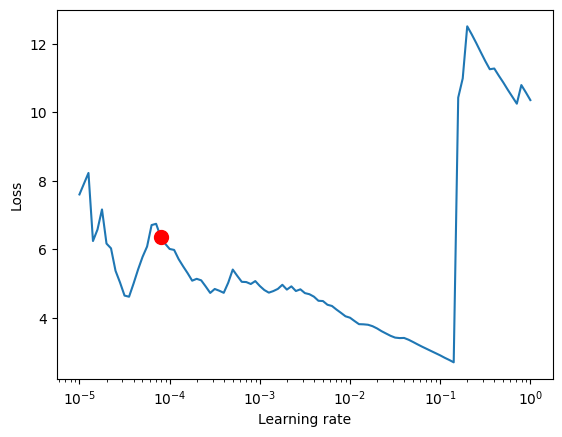

In [38]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    min_lr=1e-5,
    max_lr=1e0,
    early_stop_threshold=100,
)
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()
net.hparams.learning_rate = res.suggestion()

In [39]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=50,
    enable_checkpointing=True,
)


net = DeepAR.from_dataset(
    training,
    learning_rate=1e-2,
    log_interval=10,
    log_val_interval=1,
    hidden_size=30,
    rnn_layers=2,
    optimizer="Adam",
    loss=MultivariateNormalDistributionLoss(rank=30),
)

net.hparams.learning_rate = res.suggestion()

trainer.fit(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name                   | Type                               | Params
------------------------------------------------------------------------------
0 | loss                   | MultivariateNormalDistributionLoss | 0     
1 | logging_metrics        | ModuleList                         | 0     
2 | embeddings             | MultiEmbedding                     | 1     
3 | rnn                    | LSTM                               | 11.5 K
4 | distribution_projector | Linear                             | 992   
------------------------------------------------------------------------------
12.5 K    Trainable params
0         Non-trainable params
12.5 K    Total params
0.050     Total estimated model params size (MB)


Epoch 49: 100%|██████████| 50/50 [00:04<00:00, 10.26it/s, v_num=77, train_loss_step=-.213, val_loss=-.131, train_loss_epoch=0.0071]    

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 50/50 [00:05<00:00,  9.93it/s, v_num=77, train_loss_step=-.213, val_loss=-.131, train_loss_epoch=0.0071]


In [40]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = DeepAR.load_from_checkpoint(best_model_path)

In [41]:
# best_model = net
predictions = best_model.predict(val_dataloader, trainer_kwargs=dict(accelerator="cpu"), return_y=True)
MAE()(predictions.output, predictions.y)

net = best_model

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [42]:
raw_predictions = net.predict(
    val_dataloader, mode="raw", return_x=True, return_index=True, n_samples=100, trainer_kwargs=dict(accelerator="cpu")
)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


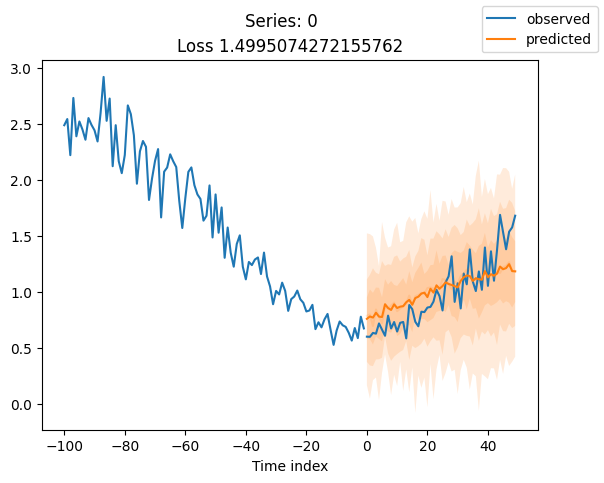

In [43]:
series = validation.x_to_index(raw_predictions.x)["series"]
for idx in range(1):  # plot 10 examples
    best_model.plot_prediction(raw_predictions.x, raw_predictions.output, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"Series: {series.iloc[idx]}")